<a href="https://colab.research.google.com/github/valeriopagliarino/Electronics-2021-UNITO/blob/main/analysis/1_Introduction_and_OPA_amplifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data analysis: Introduction and OPA amplifiers
### October 4th 2021
<p>
Authors: <b> Stefano Barbero, Valerio Pagliarino, Matteo Barbagiovanni, Federico Malnati </b> <p>Electronics Laboratory 2021 - Department of Physics - University of Turin <p>
Date: 04/10/2021

1. Instrumentation configuration
2. Probe compensation
3. Half-wave diode rectifier
4. OPA zero crossing 
5. OPA inverting zero crossing
6. OPA slew rate frequency sweep
7. OPA open ring biased threshold
8. OPA closed loop non inverting G = 2
9. OPA closed loop non inverting G = 10
10. OPA closed loop inverting bode plots for G = 1
11. OPA closed loop inverting bode plots for G = 10


## Configuration

### Clone the GIT

In [1]:
!rm -r ./sample_data
import os
from getpass import getpass
user = input('GitHub user')
mail = input('GitHub email')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password
!git clone https://$GITHUB_AUTH@github.com/valeriopagliarino/Electronics-2021-UNITO.git
!git config --global user.email user
!git config --global user.name mail

GitHub uservaleriopagliarino
GitHub emailvalerio.pagliarino@edu.unito.it
GitHub password··········
Cloning into 'Electronics-2021-UNITO'...
remote: Enumerating objects: 381, done.
remote: Counting objects: 100% (381/381), done.
remote: Compressing objects: 100% (304/304), done.
remote: Total 381 (delta 188), reused 173 (delta 65), pack-reused 0
Receiving objects: 100% (381/381), 16.91 MiB | 18.78 MiB/s, done.
Resolving deltas: 100% (188/188), done.


### Install environment

In [2]:
exec(open("./Electronics-2021-UNITO/analysis/ROOT-config.py").read())

Start config for JupyROOT Env. on Google Coolab - It takes about 3 minutes
WGET...
Done.
UNZIP...
TAR...
APT...
Installation completed.
Shared objects loaded.
Welcome to JupyROOT 6.14/04
Completed!


### Importa moduli [no COLAB]

In [ ]:
import numpy as np
import scipy as sp
import sympy as sy
import pandas as pd

from matplotlib import pyplot as plt

from uncertainties import ufloat
import uncertainties.umath

import pickle

import ROOT # Per COLAB importato da ROOT-config.py

### Importa moduli [COLAB]

In [11]:
%cd /content/
!pip3 install uncertainties
import numpy as np
import scipy as sp
import sympy as sy
import pandas as pd

from uncertainties import ufloat
import uncertainties.umath
from matplotlib import pyplot as plt
import pickle

#Pickle with dict of Numpy arrays

/content


### Funzioni per l'importazione file Tektronix

In [59]:
import csv

def cellFromCSV(path, row_index, col_index):
  with open(path, 'r') as f:
    mycsv = csv.reader(f)
    column = []
    for row in mycsv:
        column.append(row[col_index])

  return column[row_index]


def openTek(path):
  a = pd.read_table(path, header=None, sep=",", usecols=[3,4])
  a = a.transpose()
  a = a.rename(index={3: 'Time', 4: 'Amplitude'})
  a = a.transpose()

  data = {'Record lenght': cellFromCSV(path, 0, 1),
          'Sample interval': cellFromCSV(path, 1, 1),
          'Trigger point': cellFromCSV(path, 2, 1),
          'Source': cellFromCSV(path, 6, 1),
          'Vertical units': cellFromCSV(path, 7, 1),
          'Vertical scale': cellFromCSV(path, 8, 1),
          'Vertical offset': cellFromCSV(path, 9, 1),
          'Horizontal units': cellFromCSV(path, 10, 1),
          'Horizontal scale': cellFromCSV(path, 11, 1),
          'Pt FMT': cellFromCSV(path, 12, 1),
          'Y zero': cellFromCSV(path, 13, 1),
          'Probe atten': cellFromCSV(path, 14, 1),
          'Model': cellFromCSV(path, 15, 1),
          'Serial': cellFromCSV(path, 16, 1),
          'Firmware': cellFromCSV(path, 17, 1),
          'Data' : a
  }
  return data

## Half-wave rectifier

/content
dict_keys(['Record lenght', 'Sample interval', 'Trigger point', 'Source', 'Vertical units', 'Vertical scale', 'Vertical offset', 'Horizontal units', 'Horizontal scale', 'Pt FMT', 'Y zero', 'Probe atten', 'Model', 'Serial', 'Firmware', 'Data'])


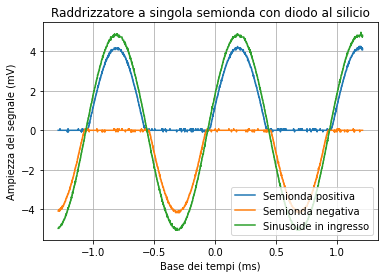

In [103]:
%cd /content

ch1_f = openTek('./Electronics-2021-UNITO/data-source/4-10-21/half_wave_rectifier_hi/F0002CH1.CSV')
ch2_f = openTek('./Electronics-2021-UNITO/data-source/4-10-21/half_wave_rectifier_hi/F0002CH2.CSV')
ch1_l = openTek('./Electronics-2021-UNITO/data-source/4-10-21/half_wave_rectifier_lo/F0003CH1.CSV')
ch2_l = openTek('./Electronics-2021-UNITO/data-source/4-10-21/half_wave_rectifier_lo/F0003CH2.CSV')
print(ch2_f.keys())

input_1 = ch1_f['Data'].to_numpy()
upper_half_wave = ch2_f['Data'].to_numpy()

input_2 = ch1_l['Data'].to_numpy()
lower_half_wave = ch2_l['Data'].to_numpy()

time1 = upper_half_wave.transpose()[0]
time2 = lower_half_wave.transpose()[0]
input_1  = input_1.transpose()[1]
input_2  = input_2.transpose()[1]
upper   = upper_half_wave.transpose()[1]
lower   = lower_half_wave.transpose()[1]

fig, ax = plt.subplots()
ax.plot(time1 * 1e3, upper, label = "Semionda positiva")
ax.plot(time2 * 1e3, lower, label = "Semionda negativa")
ax.plot(time1 * 1e3, input_1, label = "Sinusoide in ingresso")


ax.set(xlabel='Base dei tempi (ms)', ylabel='Ampiezza del segnale (mV)',
       title='Raddrizzatore a singola semionda con diodo al silicio')
ax.grid()
ax.legend()

#(ch2_f['Data'])

## Commit changes

In [ ]:
%cd /content/Electronics-2021-UNITO/
!git add .
!git commit -m "Update from Colab"
!git push 

/content/Electronics-2021-UNITO
[main e21b82d] Update from Colab
 1 file changed, 1 insertion(+), 1 deletion(-)
Counting objects: 5, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (5/5), 353 bytes | 353.00 KiB/s, done.
Total 5 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/valeriopagliarino/Electronics-2021-UNITO.git
   ae81715..e21b82d  main -> main
